In [1]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd

import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#Carga de datos
df = pd.read_excel('League 2011-12 Match by Match.xlsx')

In [9]:
#Forma de los datos
df.head()

,Date,Player ID,Player Surname,Player Forename,Team,Team Id,Opposition,Opposition id,Venue,Position Id,...,Pass Left,Pass Right,Unsuccessful Ball Touch,Successful Ball Touch,Take-Ons Overrun,CompId,SeasId,Touches open play final third,Touches open play opp box,Touches open play opp six yards
0,2012-04-28,28566,Abou Diaby,Vassiriki,Arsenal,3,Stoke City,110,Away,4,...,2,4,0,0,0,8,2011,2,1,0
1,2011-11-26,28566,Abou Diaby,Vassiriki,Arsenal,3,Fulham,54,Home,4,...,5,7,0,0,0,8,2011,11,1,0
2,2012-03-03,28566,Abou Diaby,Vassiriki,Arsenal,3,Liverpool,14,Away,4,...,5,3,2,0,0,8,2011,4,0,0
3,2012-04-21,28566,Abou Diaby,Vassiriki,Arsenal,3,Chelsea,8,Home,4,...,6,9,0,0,0,8,2011,8,1,0
4,2012-01-03,20208,Adam,Charlie,Liverpool,14,Manchester City,43,Away,4,...,13,12,0,4,0,8,2011,16,3,0


In [10]:
df_defensa = df[df['Position Id'] == 2]
print("La posición de defensa cuenta con:", df_defensa.shape[0], "Registros diferentes.",
     "\nAdicionalmente, existen", len(df_defensa["Player ID"].unique()), "defensas diferentes.")
df_defensa.head()

La posición de defensa cuenta con: 3260 Registros diferentes. 
Adicionalmente, existen 175 defensas diferentes.


,Date,Player ID,Player Surname,Player Forename,Team,Team Id,Opposition,Opposition id,Venue,Position Id,...,Pass Left,Pass Right,Unsuccessful Ball Touch,Successful Ball Touch,Take-Ons Overrun,CompId,SeasId,Touches open play final third,Touches open play opp box,Touches open play opp six yards
124,2012-01-03,21094,Agger,Daniel,Liverpool,14,Manchester City,43,Away,2,...,5,18,0,2,0,8,2011,1,0,0
125,2011-08-13,21094,Agger,Daniel,Liverpool,14,Sunderland,56,Home,2,...,9,6,0,2,0,8,2011,2,0,1
126,2012-05-08,21094,Agger,Daniel,Liverpool,14,Chelsea,8,Home,2,...,18,2,1,0,0,8,2011,9,3,1
127,2011-11-05,21094,Agger,Daniel,Liverpool,14,Swansea City,80,Home,2,...,18,7,0,0,0,8,2011,7,4,0
128,2011-12-05,21094,Agger,Daniel,Liverpool,14,Fulham,54,Away,2,...,17,15,0,2,0,8,2011,8,1,0


In [11]:
col_eliminar = []
for col in df_defensa.columns:
    if not df_defensa[col].mad()>0:
        col_eliminar.append(col)

df_defensa.drop(col_eliminar, axis = 1, inplace = True)
print("Se han eliminado las columnas:", col_eliminar, 
      "\n reteniendo únicamente", df_defensa.shape[1], "columnas.")

Se han eliminado las columnas: ['Date', 'Player Surname', 'Player Forename', 'Team', 'Opposition', 'Venue', 'Position Id', 'Appearances', 'Penalties Saved', 'Penalties Off Target', 'Penalties Not Scored', 'Other Blocked Shots', 'Attempts from Penalties off target', 'Goal Assist Goal Kick', 'Key Goal Kick', 'Goals Conceded', 'Goals Conceded Inside Box', 'Goals Conceded Outside Box', 'Saves Made', 'Saves Made from Inside Box', 'Saves Made from Outside Box', 'Saves from Penalty', 'Catches', 'Drops', 'Crosses not Claimed', 'Team Clean sheet', 'Shots On Conceded', 'Shots On Conceded Inside Box', 'Shots On Conceded Outside Box', 'Turnovers', 'Big Chances Faced', 'CompId', 'SeasId'] 
 reteniendo únicamente 177 columnas.


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Teniendo en cuenta que los goles para el caso de la posición de defensa no son tan determinantes y que en solo en el 3% de los partidos un defensa marca gol, eliminamos las variables relacionadas

In [13]:
col_eliminar = []
for col in df_defensa.columns:
    if not df_defensa.loc[df_defensa["Goals"] == 0, col].mad()>0:
        col_eliminar.append(col)

df_defensa.drop(col_eliminar, axis = 1, inplace = True)
print("Se han eliminado las columnas:", col_eliminar, 
      "\n reteniendo únicamente", df_defensa.shape[1], "columnas.")

Se han eliminado las columnas: ['Goals', 'Winning Goal', 'Penalties Taken', 'Penalty Goals', 'Direct Free-kick Goals', 'Goals from Inside Box', 'Goals from Outside Box', 'Headed Goals', 'Left Foot Goals', 'Right Foot Goals', 'Other Goals', 'Other Shots On Target', 'Goals from Throws', 'Goals from Direct Free Kick', 'Goals from penalties', 'Attempts from Penalties on target', 'Goals as a substitute'] 
 reteniendo únicamente 160 columnas.


Agregamos los datos de cada jugador, teniendo en cuenta que queremos comparar los jugadores entre si, y no por partido individual.

In [14]:
df_defensa = df_defensa.groupby(['Player ID']).sum()
df_defensa.head()

,Team Id,Opposition id,Time Played,Starts,Substitute On,Substitute Off,First Goal,Shots On Target inc goals,Shots Off Target inc woodwork,Blocked Shots,...,Pass Forward,Pass Backward,Pass Left,Pass Right,Unsuccessful Ball Touch,Successful Ball Touch,Take-Ons Overrun,Touches open play final third,Touches open play opp box,Touches open play opp six yards
Player ID,,,,,,,,,,,,,,,,,,,,,
973,1870,475,1282,16,1,8,0,0,1,1,...,162,35,44,56,4,10,1,31,3,1
1059,884,562,1424,15,2,1,0,0,4,0,...,207,44,85,88,5,13,0,20,8,2
1131,448,238,651,8,0,1,1,2,1,2,...,104,26,45,57,3,9,0,8,4,1
1216,1144,872,1704,19,3,1,0,3,8,0,...,296,34,119,40,4,8,0,67,15,3
1587,750,814,1982,21,4,0,0,0,2,4,...,243,65,164,80,6,21,0,21,13,0


Retiramos todas las variables categotricas o identificativas

In [15]:
df_defensa.columns

Index(['Team Id', 'Opposition id', 'Time Played', 'Starts', 'Substitute On',
       'Substitute Off', 'First Goal', 'Shots On Target inc goals',
       'Shots Off Target inc woodwork', 'Blocked Shots',
       ...
       'Pass Forward', 'Pass Backward', 'Pass Left', 'Pass Right',
       'Unsuccessful Ball Touch', 'Successful Ball Touch', 'Take-Ons Overrun',
       'Touches open play final third', 'Touches open play opp box',
       'Touches open play opp six yards'],
      dtype='object', length=159)

In [17]:
col_eliminar = ["Team Id", 'Opposition id']
df_defensa.drop(col_eliminar, axis = 1, inplace = True)

El número de variables aun es demasiado alto para hacer un análisis uno a uno. Por lo tanto, vamos a utilizar svd para reducir dimensiones

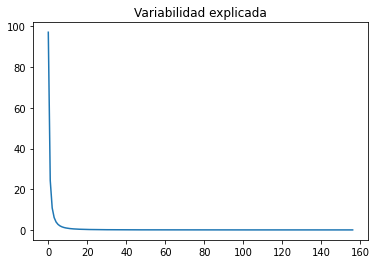

In [19]:
scaler = StandardScaler()
scaler.fit(df_defensa)
df_defensa_transformada =scaler.transform(df_defensa)

U, S, VT = svd(df_defensa_transformada, full_matrices=False)

idx = range(len(S))
func = [S[0]/((i+1) ** 2) for i in idx ]
plt.plot(idx,func) 
plt.title("Variabilidad explicada")
plt.show()

In [29]:
var_explained = np.round(S**2/np.sum(S**2), decimals=6)
num_components = 29
sum(var_explained[0:num_components])

0.9008340000000001

Al retener 29 componentes del espacio vectorial transformado, mantenemos el $90\%$ de la variabilidad o información

In [30]:
df_defensa_transformada = df_defensa_transformada @ VT[:num_components,:].T

In [35]:
df_defensa_transformada.shape

(175, 29)

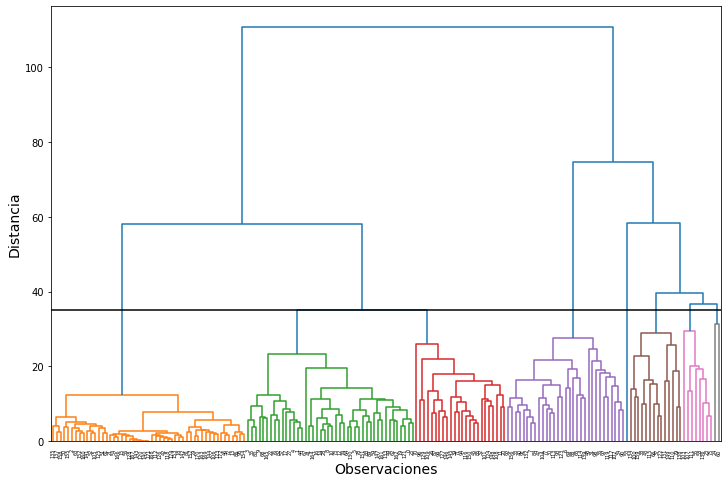

In [41]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

dist = pdist(df_defensa_transformada, metric='euclidean')
Z = linkage(dist, method='ward')

distancia_max = 35

fig, ax = plt.subplots(figsize=(12, 8))
d = dendrogram(Z, ax=ax, color_threshold=distancia_max)
ax.set_xlabel('Observaciones', fontsize=14)
ax.set_ylabel('Distancia', fontsize=14)
plt.axhline(y=distancia_max, c='k')
plt.show()

En la gráfica anterior, al definir una distacia máxima de 35, tendríamos 8 grupos. Sin embargo dos grupos solo contienen uno o dos elementos.

In [42]:
from scipy.cluster.hierarchy import fcluster
cluster_jerarquico = fcluster(Z, distancia_max, criterion="distance")
print("En el orden inicial, cada registro pertenecería al siguiente cluster:", cluster_jerarquico)

En el orden inicial, cada registro pertenecería al siguiente cluster: [2 2 1 2 2 2 4 4 2 2 2 3 2 1 2 1 2 2 1 2 3 1 2 6 7 2 3 2 2 1 4 4 3 4 4 2 4
 5 5 3 4 2 1 5 2 3 1 4 4 2 1 1 1 8 1 6 1 2 6 2 7 1 2 1 2 4 5 2 2 4 3 3 1 2
 2 6 2 4 2 5 2 1 2 2 4 3 1 3 4 2 4 4 4 4 3 1 3 4 4 3 5 3 4 6 4 1 1 6 3 3 5
 6 1 4 4 5 3 4 1 4 1 2 5 4 3 1 1 3 1 3 2 5 4 2 5 1 6 1 5 4 1 1 1 1 1 3 3 2
 3 5 3 2 1 1 1 1 4 1 1 5 1 2 2 1 2 2 1 1 1 1 1 1 1 1 1]


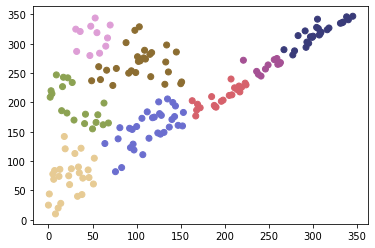

In [53]:
from sklearn.cluster import AgglomerativeClustering

cluster_sk = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='ward')
cluster_sk =cluster_sk.fit_predict(Z)

plt.scatter(Z[:,0], Z[:,1], c=cluster_sk, cmap='tab20b')
plt.show()